In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [5]:
r"C:\Users\KARAN\AppData\Local\R\win-library\4.3\spatialLIBD\data"

'C:\\Users\\KARAN\\AppData\\Local\\R\\win-library\\4.3\\spatialLIBD\\data'

In [6]:
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.3.0"
os.environ['R_USER'] = r"C:\Users\KARAN\anaconda3\envs\STAGATE_PT\Lib\site-packages\rpy2"


In [7]:

import STAGATE


In [8]:
section_id = '151673'

In [9]:
file = r'Data1\151673'
adata = sc.read_visium(file, count_file=r'filtered_feature_bc_matrix.h5',load_images=True)
adata.var_names_make_unique()

In [10]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [13]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('Data1', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [16]:
Ann_df

,Ground Truth
0,
AAACAAGTATCTCCCA-1,Layer_3
AAACAATCTACTAGCA-1,Layer_1
AAACACCAATAACTGC-1,WM
AAACAGAGCGACTCCT-1,Layer_3
AAACAGCTTTCAGAAG-1,Layer_5
...,...
TTGTTTCACATCCAGG-1,WM
TTGTTTCATTAGTCTA-1,WM
TTGTTTCCATACAACT-1,Layer_6


In [17]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']


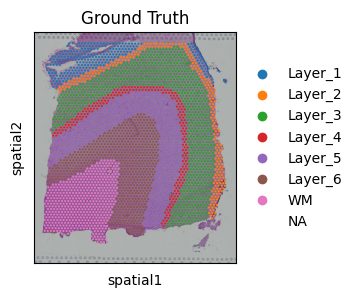

In [18]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.


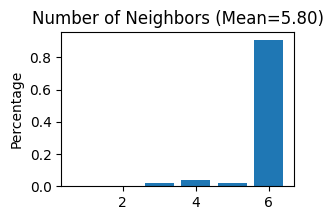

In [19]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

In [20]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (3639, 3000)


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


In [22]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [24]:
from sklearn.metrics.cluster import adjusted_rand_score

In [25]:
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

fitting ...
  |======================================================================| 100%
Adjusted rand index = 0.59


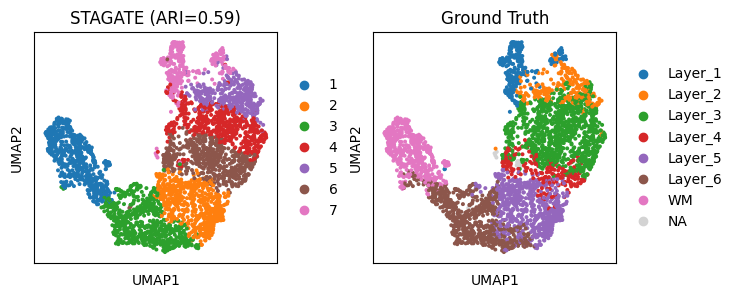

In [26]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

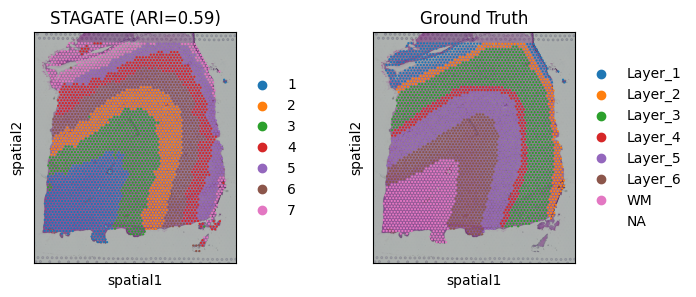

In [27]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

spatial traj (paga)

In [28]:
used_adata = adata[adata.obs['Ground Truth']!='nan',]
used_adata

View of AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net', 'neighbors', 'umap', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'